# Predicting Laptop Prices
#### Préparé par : Mouad AIT HAMMOU

## I. Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# We start by loading our csv file
df = pd.read_csv("laptopData.csv")
# This is a sample rows from it
df.sample(3)

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
1048,1048.0,Lenovo,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 980M,Windows 10,4.6kg,122010.6672
142,142.0,Lenovo,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia GeForce GTX 1050M,No OS,2.4kg,46300.3200
484,484.0,Lenovo,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,2.3kg,30103.2000


## II. Cleaning

In [3]:
# We'll drop the 1st column (it just represent indexes)
df.drop(columns='Unnamed: 0',inplace=True)
# Here's an overview on our data, we can remarque that there is missing rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1273 non-null   object 
 1   TypeName          1273 non-null   object 
 2   Inches            1273 non-null   object 
 3   ScreenResolution  1273 non-null   object 
 4   Cpu               1273 non-null   object 
 5   Ram               1273 non-null   object 
 6   Memory            1273 non-null   object 
 7   Gpu               1273 non-null   object 
 8   OpSys             1273 non-null   object 
 9   Weight            1273 non-null   object 
 10  Price             1273 non-null   float64
dtypes: float64(1), object(10)
memory usage: 112.1+ KB


In [4]:
# Before we start cleaning, we'll handle missing data :
# Let's count the number of missing values on each column : There is 30 in each one
display(df.isnull().sum())
# 30 row is not that much compared to the +1270 row that we have, let's drop it
df.dropna(inplace=True)

Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [5]:
# We'll start cleaning column by column, starting with the "company" column
df['Company'].value_counts()
# The count shows that there is 19 different value, no spelling mistakes
# This column doesn't need any preprocessing

Lenovo       290
Dell         287
HP           266
Asus         156
Acer         103
MSI           53
Toshiba       47
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
LG             3
Huawei         2
Fujitsu        2
Name: Company, dtype: int64

In [6]:
# The "TypeName" column contain the laptop type
type_counts = df['TypeName'].value_counts()
display(type_counts)
# The following count shows that the 'Workstation' and the 'Netbook' types are rare compared to other types
# We'll create a new 'others' type that contain those rare types
rare_type = type_counts[type_counts<=30].index
df['TypeName'] = df['TypeName'].replace(rare_type,'Others')
print("After cleaning :")
df['TypeName'].value_counts()

Notebook              710
Gaming                203
Ultrabook             191
2 in 1 Convertible    116
Workstation            29
Netbook                24
Name: TypeName, dtype: int64

After cleaning :


Notebook              710
Gaming                203
Ultrabook             191
2 in 1 Convertible    116
Others                 53
Name: TypeName, dtype: int64

In [7]:
# The "Inches" column describe the laptop screen size
display(df['Inches'].describe())
# We can see that the column type isn't numerical, we need to change it
df['Inches'] = pd.to_numeric(df['Inches'], errors='coerce')
df = df.dropna(subset=['Inches'])
print("After cleaning :")
df['Inches'].describe()

count     1273
unique      25
top       15.6
freq       640
Name: Inches, dtype: object

After cleaning :


count    1272.000000
mean       15.130818
std         1.954436
min        10.100000
25%        14.000000
50%        15.600000
75%        15.600000
max        35.600000
Name: Inches, dtype: float64

In [8]:
# We had the idea of adding a new categorical column ("ScreenSizeGroup")
# This column will be describing the screen size based on the "Inches" column ('Small', 'Medium', 'Large')
screen_size_ranges = df['Inches'].quantile([0,0.25, 0.5, 0.75, 1])
screen_size_labels = [ 'Small', 'Medium', 'Large']
# Using pandas.cut to create a new column with screen size groups
df['ScreenSizeGroup'] = pd.cut(df['Inches'],bins=screen_size_ranges, labels=screen_size_labels,
                               include_lowest=True, duplicates='drop')
df[['Inches', 'ScreenSizeGroup']].sample(3)

,Inches,ScreenSizeGroup
359,14.0,Small
903,14.0,Small
1166,15.6,Medium


In [9]:
# The "ScreenResolution" containe a lot of tech terms beside the resolution
# We'll remove the extra text and only leave the resolution
display(df['ScreenResolution'].head(5))

def cleanResolution(s) :
    match = re.search(r'\d+x\d+', s)
    if match:
        return match.group()
    return np.nan

df['ScreenResolution'] = df['ScreenResolution'].apply(cleanResolution)
print("After cleaning :")
df['ScreenResolution'].head(5)

0    IPS Panel Retina Display 2560x1600
1                              1440x900
2                     Full HD 1920x1080
3    IPS Panel Retina Display 2880x1800
4    IPS Panel Retina Display 2560x1600
Name: ScreenResolution, dtype: object

After cleaning :


0    2560x1600
1     1440x900
2    1920x1080
3    2880x1800
4    2560x1600
Name: ScreenResolution, dtype: object

In [10]:
# The "Cpu" column contains a lot of informations, let's split it into two columns
# The "ProcessorType" and the "ClockSpeed"
display(df[['Cpu']].head(5))

def cleanCpu(cpu_info, t="clock_speed"):
    match = re.search(r'(.+?)\s*([0-9.]+GHz)', cpu_info)
    if match:
        processor_type = match.group(1).strip()
        clock_speed = float(match.group(2)[:-3])
        return processor_type if t=="processor_type" else clock_speed
    return np.nan
df['ProcessorType'] = df['Cpu'].apply(cleanCpu, t="processor_type")
df['ClockSpeed'] = df['Cpu'].apply(cleanCpu)
df.drop(columns=['Cpu'], inplace=True)
print("After cleaning :")
display(df[['ProcessorType', 'ClockSpeed']].head(5))

,Cpu
0,Intel Core i5 2.3GHz
1,Intel Core i5 1.8GHz
2,Intel Core i5 7200U 2.5GHz
3,Intel Core i7 2.7GHz
4,Intel Core i5 3.1GHz


After cleaning :


,ProcessorType,ClockSpeed
0,Intel Core i5,2.3
1,Intel Core i5,1.8
2,Intel Core i5 7200U,2.5
3,Intel Core i7,2.7
4,Intel Core i5,3.1


In [11]:
# The "Ram" column contains the term 'GB', we all now that so we need to delete it
# Also the type must change to int
display(df[['Ram']].head(5))

def cleanRam(ram_description):
    try:
        ram_size = int(ram_description.replace('GB', '').strip())
        return ram_size
    except ValueError:
        return None

df['Ram'] = df['Ram'].apply(cleanRam)
print("After cleaning :")
df[['Ram']].head(5)

,Ram
0,8GB
1,8GB
2,8GB
3,16GB
4,8GB


After cleaning :


,Ram
0,8
1,8
2,8
3,16
4,8


In [12]:
# The "Memory" column contains the memory size + the memory type, we'll split it into two columns
# All sizes will be converted to GB and to int
# Any memory type that contain multiple types will be considered hybrid
display(df[['Memory']].head(5))

def memoryClean(m, opt='size') :
    if m=='?' : return np.nan
    if '+' in m :
        L = m.split('+')
    else : L = [m]
    n, t = [], []
    for i in L :
        s = i.split()
        n.append(float(s[0][:-2]) if s[0][-2:]=='GB' else 1024*float(s[0][:-2]))
        t.append(' '.join(s[1:]))
    N = int(sum(n))
    T = t[0] if len(t)==1 else "Hybrid" if t[0]!=t[1] else t[0]
    return N if opt=='size' else T

df['MemorySize'] = df['Memory'].apply(memoryClean)
df['MemoryType'] = df['Memory'].apply(memoryClean, opt='')
df.drop(columns=['Memory'], inplace=True)
print("After cleaning :")
df[['MemorySize', 'MemoryType']].head(5)

,Memory
0,128GB SSD
1,128GB Flash Storage
2,256GB SSD
3,512GB SSD
4,256GB SSD


After cleaning :


,MemorySize,MemoryType
0,128.0,SSD
1,128.0,Flash Storage
2,256.0,SSD
3,512.0,SSD
4,256.0,SSD


In [13]:
# The Gpu column contains 110 different GPU type, it is difficult to find a way to simplify it
# Even split it by the manifacturing company will not give enought information about the GPU
# We choosed to leave this column with no cleaning
df['Gpu'].value_counts()

Intel HD Graphics 620      271
Intel HD Graphics 520      181
Intel UHD Graphics 620      66
Nvidia GeForce GTX 1050     64
Nvidia GeForce GTX 1060     48
                          ... 
AMD Radeon R5 520            1
AMD Radeon R7                1
Intel HD Graphics 540        1
AMD Radeon 540               1
ARM Mali T860 MP4            1
Name: Gpu, Length: 110, dtype: int64

In [14]:
# The "OpSys" contains the different operating systems of laptops. It doesn't need any cleaning
df['OpSys'].value_counts()

Windows 10      1046
No OS             63
Linux             61
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            1
Name: OpSys, dtype: int64

In [15]:
# The "Weight" column must be float, we need to get rid of the 'kg'
display(df[['Weight']].head())
df['Weight'] = df['Weight'].apply(lambda w : float(w[:-2]) if w[:-2]!='' else np.nan)
print("After cleaning :")
df[['Weight']].head()

,Weight
0,1.37kg
1,1.34kg
2,1.86kg
3,1.83kg
4,1.37kg


After cleaning :


,Weight
0,1.37
1,1.34
2,1.86
3,1.83
4,1.37


In [16]:
# We can see that the laptops price is very high
# The data source mention that the data is scrapped from an indian website 10 months ago (mid February)
# We'll convert it to MAD using the convertion rate of mid february : 1INR = 0.1246MAD
# Also we'll round the prices to 2 significatif digits (we don't need that precison)
display(df[['Price']].head())
df['Price'] = df['Price'].apply(lambda p : round(p*0.1246, 2))
print("After cleaning :")
df[['Price']].head()

,Price
0,71378.6832
1,47895.5232
2,30636.0000
3,135195.3360
4,96095.8080


After cleaning :


,Price
0,8893.78
1,5967.78
2,3817.25
3,16845.34
4,11973.54


In [17]:
# Before we finish we'll drop any line containing missing values
df.dropna()
# That's our data Frame after cleaning, we'll save it ina json format for any use later
df.to_json("laptopData.json")
df

,Company,TypeName,Inches,ScreenResolution,Ram,Gpu,OpSys,Weight,Price,ScreenSizeGroup,ProcessorType,ClockSpeed,MemorySize,MemoryType
0,Apple,Ultrabook,13.3,2560x1600,8,Intel Iris Plus Graphics 640,macOS,1.37,8893.78,Small,Intel Core i5,2.3,128.0,SSD
1,Apple,Ultrabook,13.3,1440x900,8,Intel HD Graphics 6000,macOS,1.34,5967.78,Small,Intel Core i5,1.8,128.0,Flash Storage
2,HP,Notebook,15.6,1920x1080,8,Intel HD Graphics 620,No OS,1.86,3817.25,Medium,Intel Core i5 7200U,2.5,256.0,SSD
3,Apple,Ultrabook,15.4,2880x1800,16,AMD Radeon Pro 455,macOS,1.83,16845.34,Medium,Intel Core i7,2.7,512.0,SSD
4,Apple,Ultrabook,13.3,2560x1600,8,Intel Iris Plus Graphics 650,macOS,1.37,11973.54,Small,Intel Core i5,3.1,256.0,SSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,1920x1080,4,Intel HD Graphics 520,Windows 10,1.80,4235.48,Small,Intel Core i7 6500U,2.5,128.0,SSD
1299,Lenovo,2 in 1 Convertible,13.3,3200x1800,16,Intel HD Graphics 520,Windows 10,1.30,9951.39,Small,Intel Core i7 6500U,2.5,512.0,SSD
1300,Lenovo,Notebook,14.0,1366x768,2,Intel HD Graphics,Windows 10,1.50,1520.26,Small,Intel Celeron Dual Core N3050,1.6,64.0,Flash Storage
1301,HP,Notebook,15.6,1366x768,6,AMD Radeon R5 M330,Windows 10,2.19,5071.96,Medium,Intel Core i7 6500U,2.5,1024.0,HDD


## III. Visualisation

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

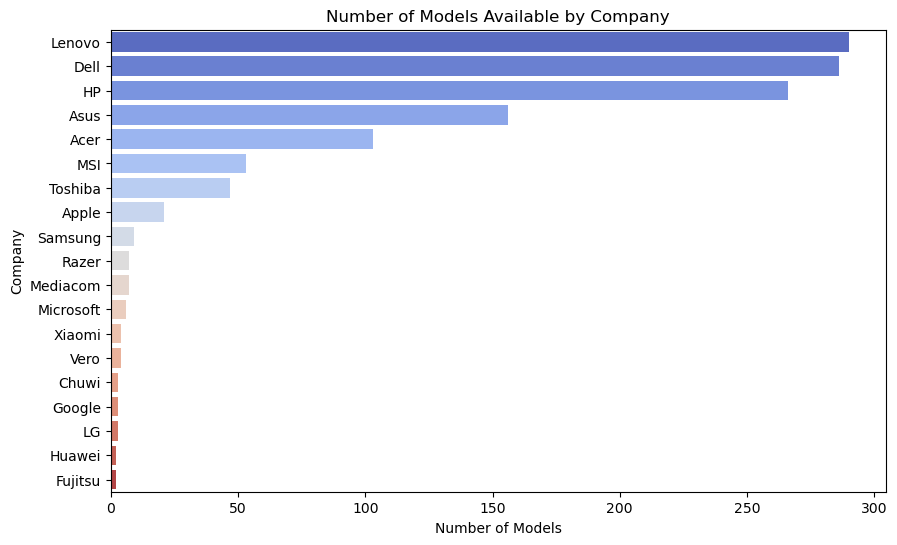

In [19]:
# Count the number of models available for each company
models_by_company = df['Company'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(y='Company', data=df, order=models_by_company.index, palette='coolwarm')
plt.xlabel('Number of Models')
plt.ylabel('Company')
plt.title('Number of Models Available by Company')
plt.show()


from the above graph we can say that dell and lenova has more number of laptops

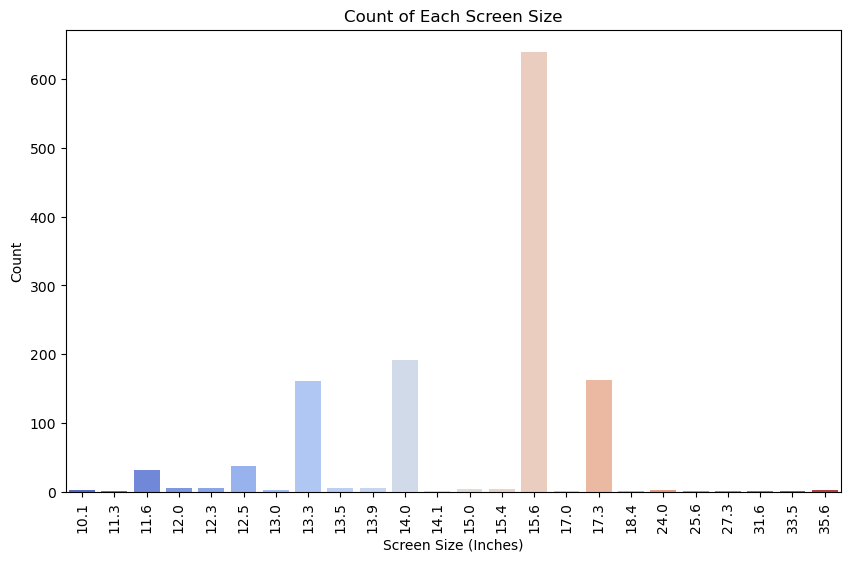

In [20]:
# Count the number of occurrences of each screen size
screen_size_counts = df['Inches'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=screen_size_counts.index, y=screen_size_counts.values, palette='coolwarm')
plt.xlabel('Screen Size (Inches)')
plt.ylabel('Count')
plt.title('Count of Each Screen Size')
plt.xticks(rotation=90)  # Rotate x-labels for better visibility
plt.show()

this graph shows the count of each screen sizes and 15.6 inch screen is in more number

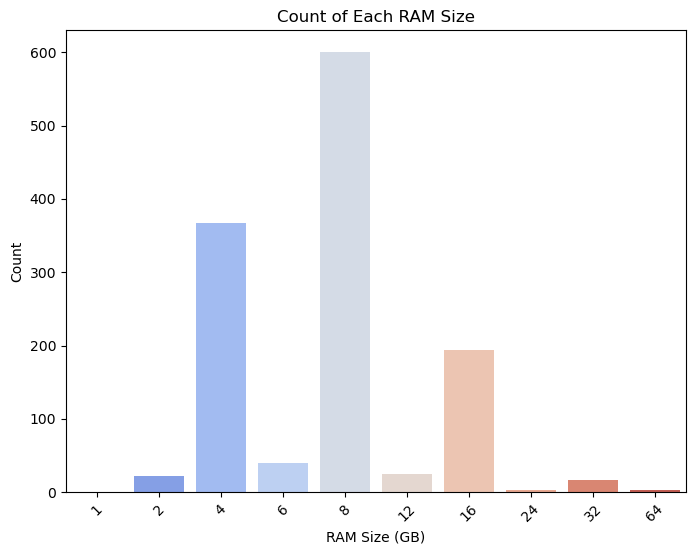

In [21]:
# Count the number of occurrences of each RAM size
ram_size_counts = df['Ram'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=ram_size_counts.index, y=ram_size_counts.values, palette='coolwarm')
plt.xlabel('RAM Size (GB)')
plt.ylabel('Count')
plt.title('Count of Each RAM Size')
plt.xticks(rotation=45)  # Rotate x-labels for better visibility
plt.show()


this graph shows the count of each RAM sizes and laptops with 8GB is in more number

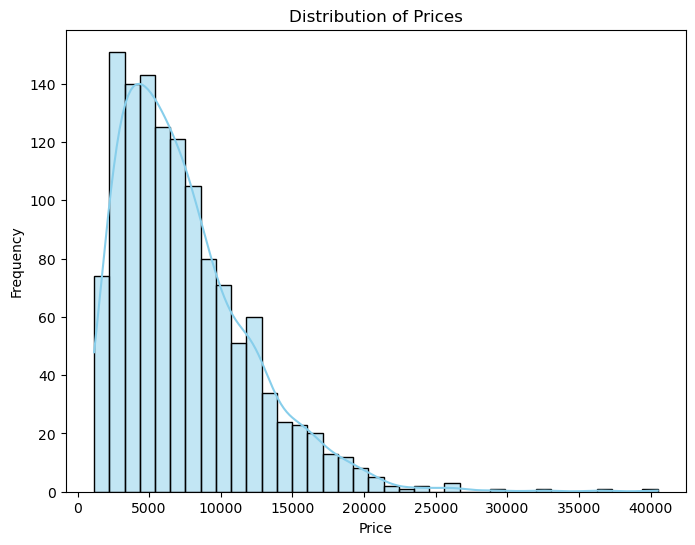

In [22]:
# Plotting the distribution of prices using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True, color='skyblue')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()


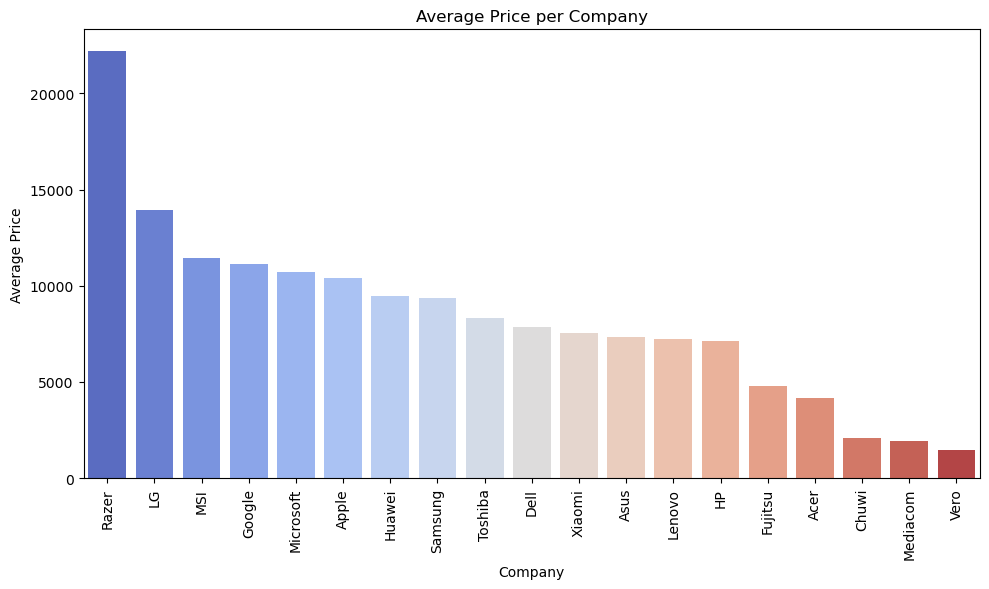

In [23]:
# Calculate the average price per company
avg_price_per_company = df.groupby('Company')['Price'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_per_company.index, y=avg_price_per_company.values, palette='coolwarm')
plt.xlabel('Company')
plt.ylabel('Average Price')
plt.title('Average Price per Company')
plt.xticks(rotation=90)  # Rotate x-labels for better visibility
plt.tight_layout()
plt.show()

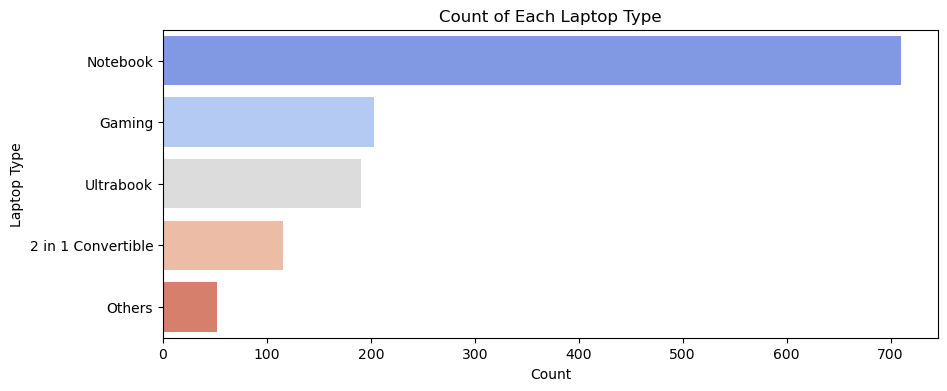

In [24]:
# Count the number of occurrences of each laptop type
laptop_type_counts = df['TypeName'].value_counts()

# Plotting
plt.figure(figsize=(10, 4))
sns.barplot(x=laptop_type_counts.values, y=laptop_type_counts.index, palette='coolwarm')
plt.xlabel('Count')
plt.ylabel('Laptop Type')
plt.title('Count of Each Laptop Type')
plt.show()

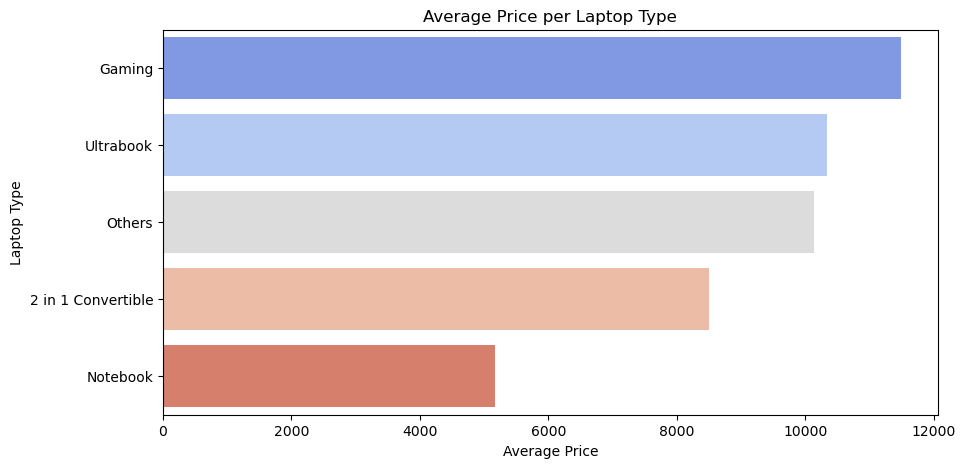

In [25]:
# Calculate the average price per laptop type
avg_price_per_type = df.groupby('TypeName')['Price'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_price_per_type.values, y=avg_price_per_type.index, palette='coolwarm')
plt.xlabel('Average Price')
plt.ylabel('Laptop Type')
plt.title('Average Price per Laptop Type')
plt.show()

In [26]:

X_resxY_res = df['ScreenResolution'].str.split('x',n=1,expand=True)
df['X_res'] = pd.to_numeric(X_resxY_res[0])
df['Y_res'] = pd.to_numeric(X_resxY_res[1])


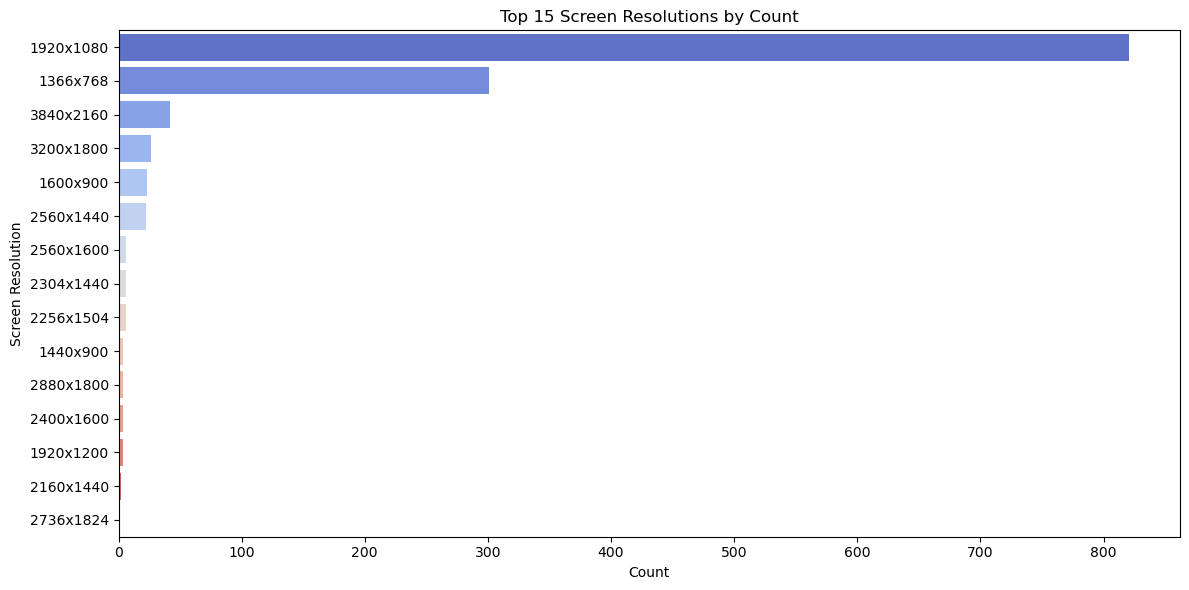

In [27]:
# Calculate the count of each screen resolution
resolution_counts = df['ScreenResolution'].value_counts().reset_index()
resolution_counts.columns = ['ScreenResolution', 'Count']
# Plotting the count of screen resolutions
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='ScreenResolution', data=resolution_counts.head(15), palette='coolwarm')
plt.xlabel('Count')
plt.ylabel('Screen Resolution')
plt.title('Top 15 Screen Resolutions by Count')
plt.tight_layout()
plt.show()

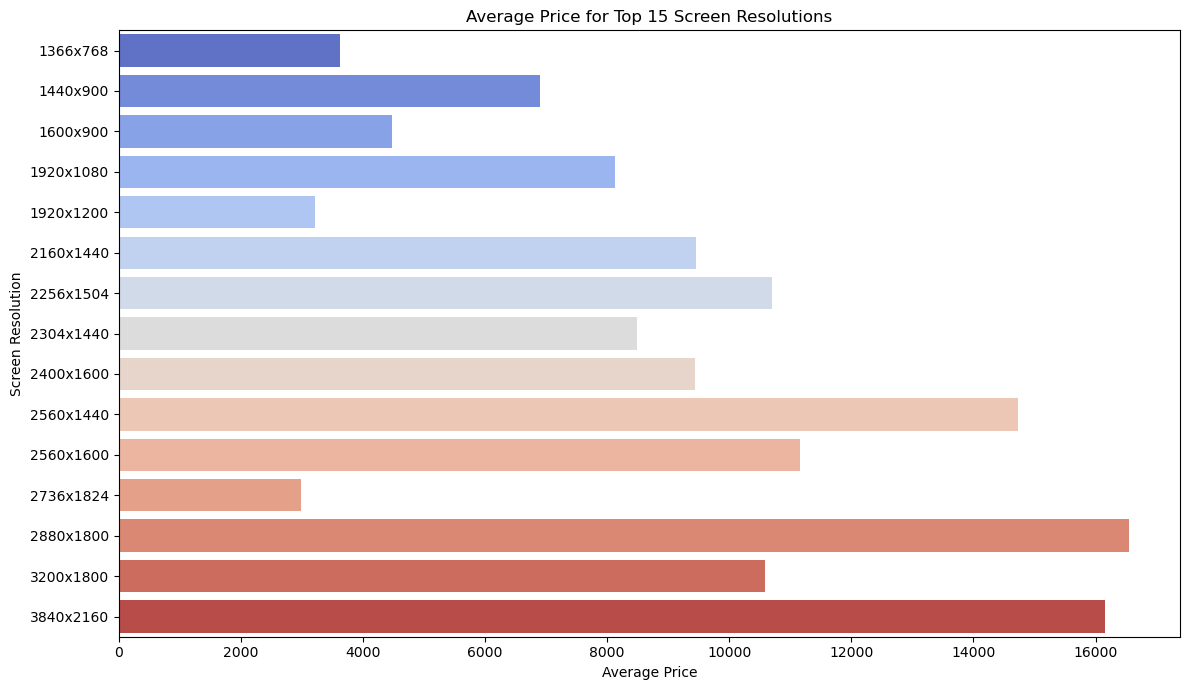

In [28]:
# Calculate the average price for each screen resolution
avg_price_per_resolution = df.groupby('ScreenResolution')['Price'].mean().reset_index()
avg_price_per_resolution.columns = ['ScreenResolution', 'Avg_Price']

# Plotting the average price for screen resolutions
plt.figure(figsize=(12, 7))
sns.barplot(x='Avg_Price', y='ScreenResolution', data=avg_price_per_resolution.head(15), palette='coolwarm')
plt.xlabel('Average Price')
plt.ylabel('Screen Resolution')
plt.title('Average Price for Top 15 Screen Resolutions')
plt.tight_layout()
plt.show()

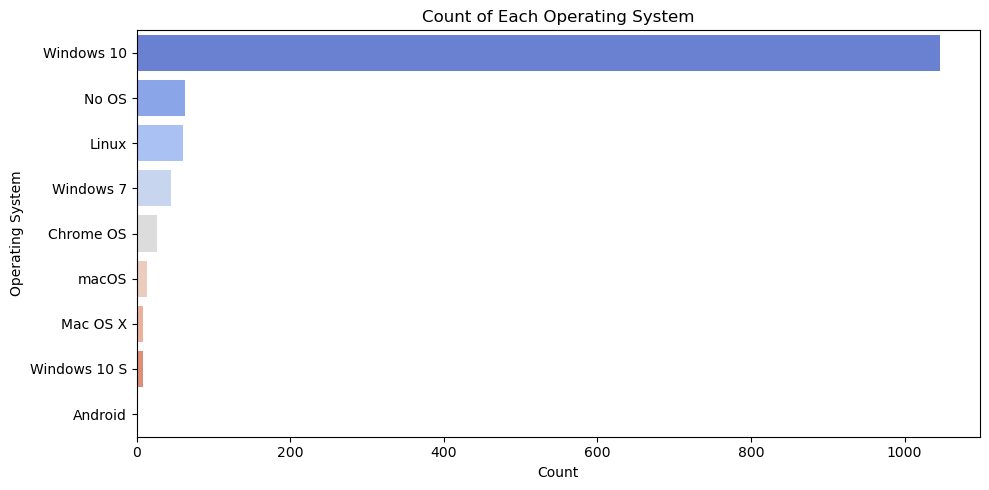

In [29]:
# Calculate the count of each operating system
os_counts = df['OpSys'].value_counts()

# Plotting the count of operating systems
plt.figure(figsize=(10, 5))
sns.barplot(x=os_counts.values, y=os_counts.index, palette='coolwarm')
plt.xlabel('Count')
plt.ylabel('Operating System')
plt.title('Count of Each Operating System')
plt.tight_layout()
plt.show()

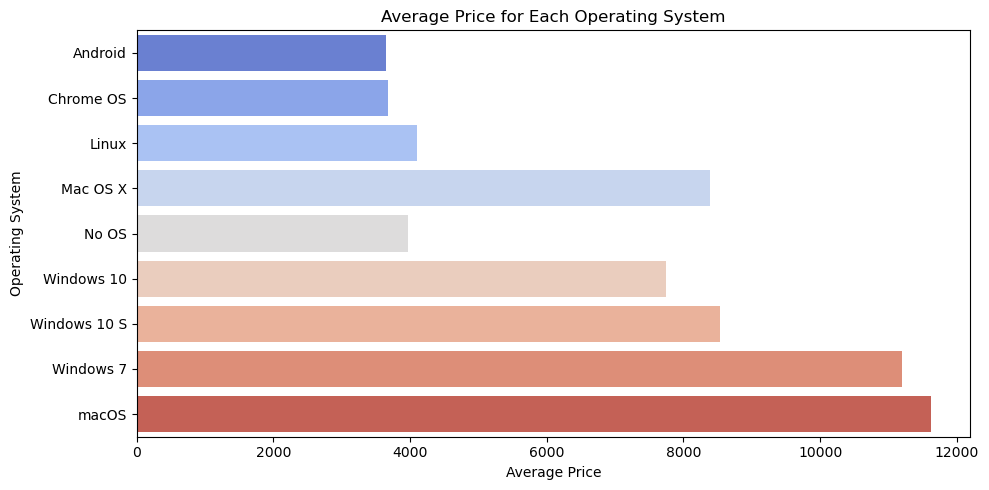

In [30]:

# Calculate the average price for each operating system
avg_price_per_os = df.groupby('OpSys')['Price'].mean()

# Plotting the average price for operating systems
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_price_per_os.values, y=avg_price_per_os.index, palette='coolwarm')
plt.xlabel('Average Price')
plt.ylabel('Operating System')
plt.title('Average Price for Each Operating System')
plt.tight_layout()
plt.show()

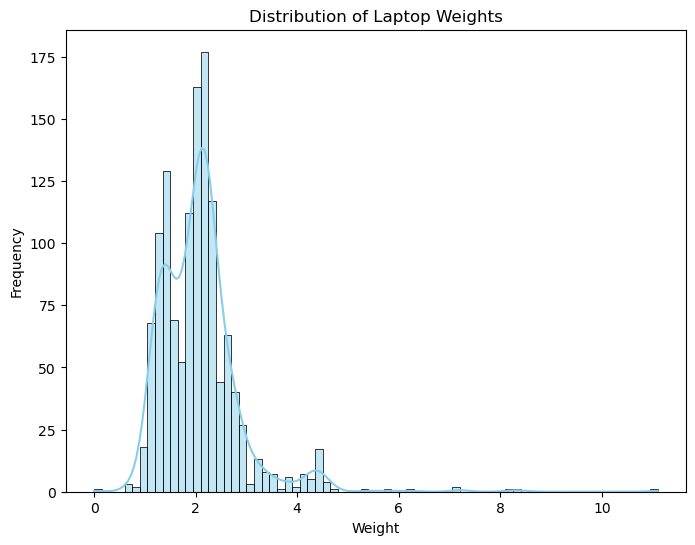

In [31]:
# Plotting the distribution of weights using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['Weight'], kde=True, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Laptop Weights')
plt.show()

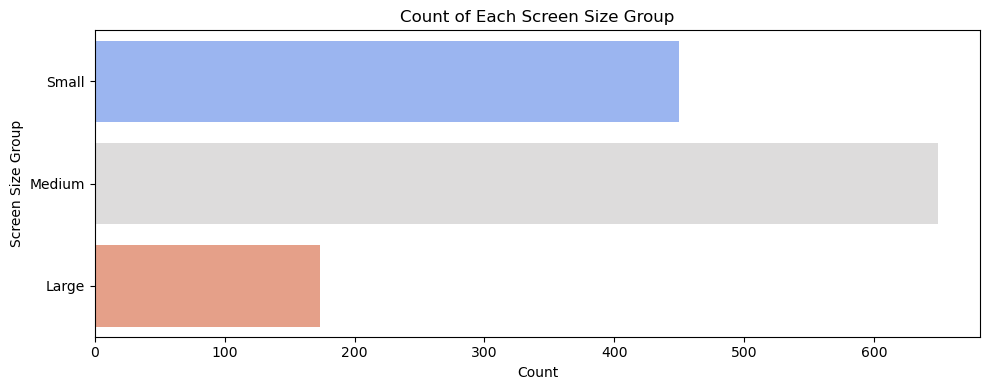

In [32]:
# Calculate the count of each screen size group
screensizegroup_counts = df['ScreenSizeGroup'].value_counts().reset_index()
screensizegroup_counts.columns = ['ScreenSizeGroup', 'Count']

# Plotting the count of screen size groups
plt.figure(figsize=(10, 4))
sns.barplot(x='Count', y='ScreenSizeGroup', data=screensizegroup_counts, palette='coolwarm')
plt.xlabel('Count')
plt.ylabel('Screen Size Group')
plt.title('Count of Each Screen Size Group')
plt.tight_layout()
plt.show()

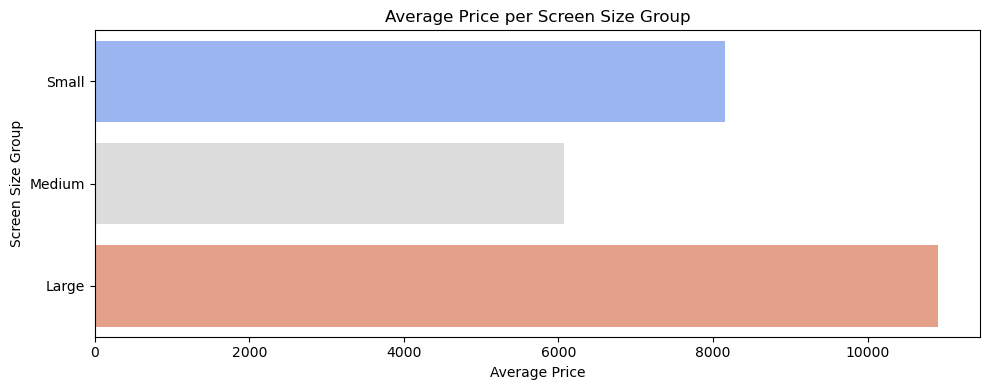

In [33]:
# Calculate the average price for each screen size group
avg_price_per_group = df.groupby('ScreenSizeGroup')['Price'].mean().reset_index()
avg_price_per_group.columns = ['ScreenSizeGroup', 'Avg_Price']

# Plotting the average price for screen size groups
plt.figure(figsize=(10, 4))
sns.barplot(x='Avg_Price', y='ScreenSizeGroup', data=avg_price_per_group, palette='coolwarm')
plt.xlabel('Average Price')
plt.ylabel('Screen Size Group')
plt.title('Average Price per Screen Size Group')
plt.tight_layout()
plt.show()

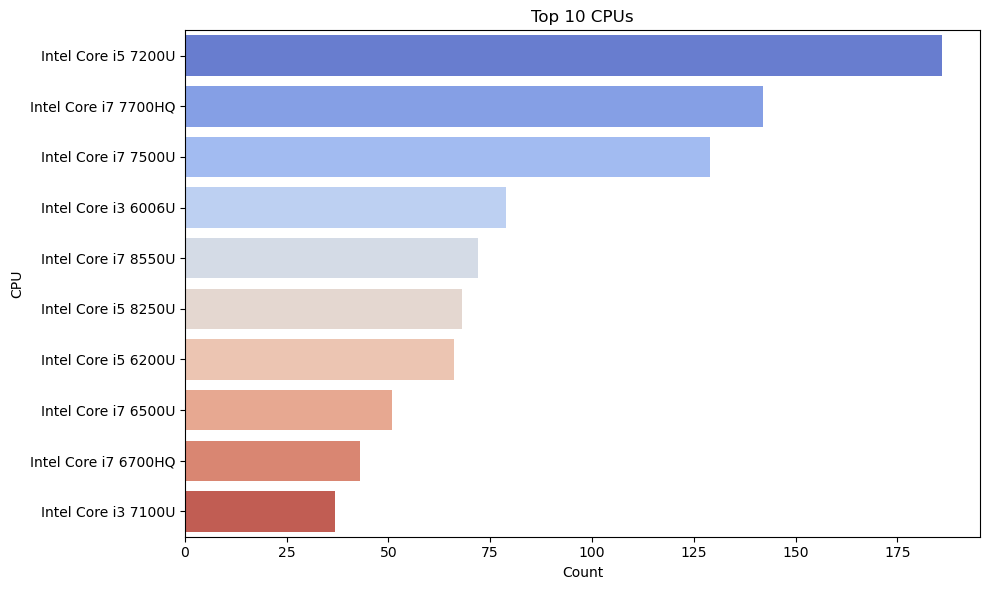

In [34]:
# Get the top 10 CPUs based on their frequency
top_10_cpus = df['ProcessorType'].value_counts().head(10)

# Plotting the top 10 CPUs
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_cpus.values, y=top_10_cpus.index, palette='coolwarm')
plt.xlabel('Count')
plt.ylabel('CPU')
plt.title('Top 10 CPUs')
plt.tight_layout()
plt.show()

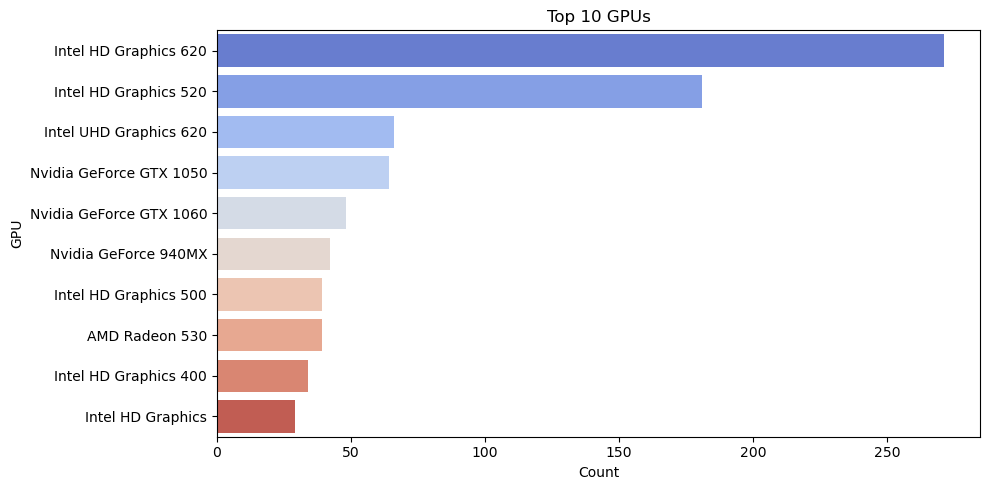

In [35]:
# Get the top 10 GPUs based on their frequency
top_10_gpus = df['Gpu'].value_counts().head(10)

# Plotting the top 10 GPUs
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_gpus.values, y=top_10_gpus.index, palette='coolwarm')
plt.xlabel('Count')
plt.ylabel('GPU')
plt.title('Top 10 GPUs')
plt.tight_layout()
plt.show()

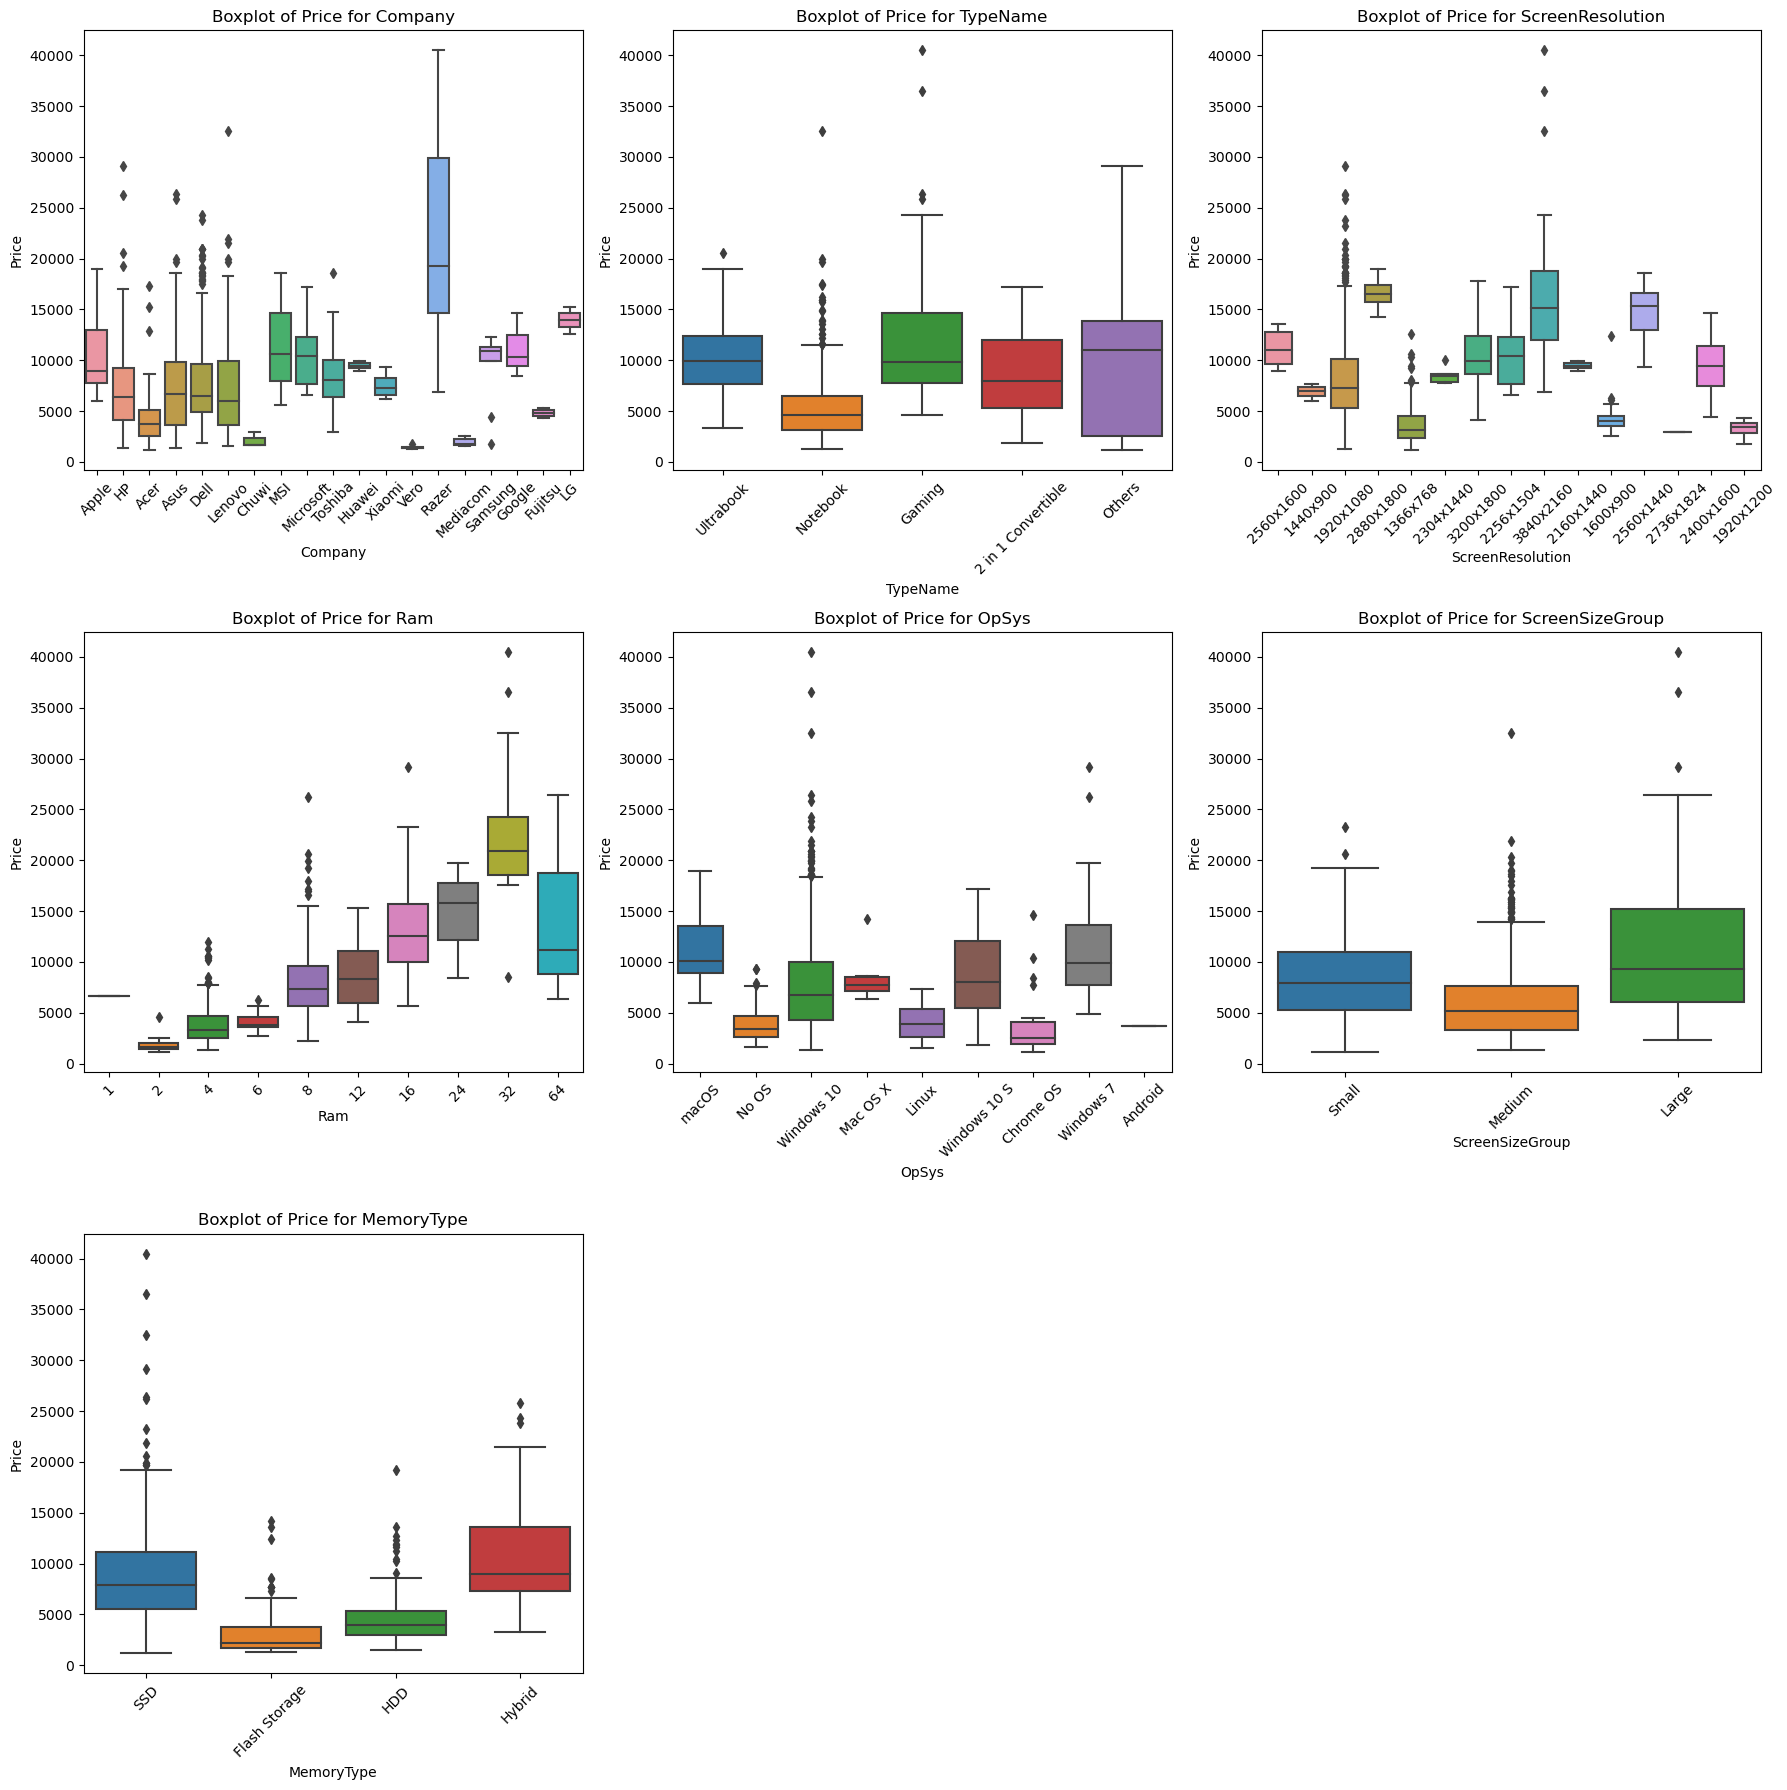

In [36]:
# Columns to create boxplots for
categorical_columns = ['Company', 'TypeName', 'ScreenResolution', 'Ram', 'OpSys', 'ScreenSizeGroup',
                       'MemoryType']

# Calculate the number of rows and columns for subplots
num_plots = len(categorical_columns)
num_cols = 3  # Number of columns for subplots
num_rows = - (- num_plots // num_cols)  # Ceiling division to get the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 6*num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through categorical columns and create boxplots
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price', data=df, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')
    axes[i].set_title(f'Boxplot of Price for {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplot(s) if present
if num_plots < len(axes):
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## IV. Prediction

In [37]:
df.dropna(inplace=True)

### preprocessing for machine learning

create categories for Gpu and ProcessorType

In [38]:
# List of GPU names
gpu_names = df["Gpu"].unique().tolist()

# Mapping GPU names to their respective categories (for illustration purposes)
gpu_categories = {
    'Intel': ['Intel Iris', 'Intel HD Graphics', 'Intel UHD Graphics'],
    'AMD': ['AMD Radeon', 'AMD FirePro'],
    'Nvidia': ['Nvidia GeForce', 'Nvidia Quadro'],
    'ARM': ['ARM Mali']
}

# Function to assign categories based on GPU names
def categorize_gpu(gpu_name):
    for brand, models in gpu_categories.items():
        for model in models:
            if model in gpu_name:
                return brand
    return 'Others'

# Creating a new column 'GPUCategory' based on the categorized brands
df['GPUCategory'] = df['Gpu'].apply(categorize_gpu)

# Displaying the count of GPUs in each category
gpu_category_count = df['GPUCategory'].value_counts()
print(gpu_category_count)

Intel     701
Nvidia    391
AMD       173
Others      4
ARM         1
Name: GPUCategory, dtype: int64


In [39]:
processor_names =df["ProcessorType"].unique().tolist()

# Mapping processor names to their respective categories (for illustration purposes)
processor_categories = {
    'Intel': {
        'High Intel': ['Intel Core i7', 'Intel Core i9', 'Intel Xeon'],
        'Medium Intel': ['Intel Core i5'],
        'Low Intel': ['Intel Core i3', 'Intel Pentium', 'Intel Celeron']
    },
    'AMD': {
        'High AMD': ['AMD Ryzen', 'AMD FX'],
        'Medium AMD': ['AMD A'],
        'Low AMD': ['AMD E']
    },
    'Samsung': ['Samsung Cortex']
}

# Function to assign categories based on processor names
def categorize_processor(processor_name):
    for brand, models in processor_categories.items():
        if brand == 'Samsung':
            continue
        for category, sub_models in models.items():
            for model in sub_models:
                if model in processor_name:
                    return category
    return 'Others'

# Creating a new column 'ProcessorCategory' based on the categorized brands
df['ProcessorCategory'] = df['ProcessorType'].apply(categorize_processor)

# Displaying the count of processors in each category
processor_category_count = df['ProcessorCategory'].value_counts()
print(processor_category_count)

High Intel      516
Medium Intel    410
Low Intel       251
Medium AMD       47
Others           31
Low AMD           9
High AMD          6
Name: ProcessorCategory, dtype: int64


encoding categorical variables

In [40]:
# Mapping processor categories to numerical values
processor_category_encoding = {'High Intel': 3,'Medium Intel': 2,'Low Intel': 1,'High AMD': 3,'Medium AMD': 2,'Low AMD': 1,'Others': 0}
# Encoding ProcessorCategory column with numerical values
df['EncodedProcessorCategory'] = df['ProcessorCategory'].map(processor_category_encoding)

# Mapping gpu categories to numerical values
gpu_category_encoding = {'Intel': 1,'Nvidia': 3,'AMD': 2,'Others': 0,'ARM': 0}
# Encoding GPUCategory column with numerical values
df['EncodedGPUCategory'] = df['GPUCategory'].map(gpu_category_encoding)

# Mapping Memory categories to numerical values
MemoryType_encoding = {'SSD': 2,'Flash Storage':0,'HDD': 1,'Hybrid': 3}
# Encoding MemoryType column with numerical values
df['EncodedMemoryType'] = df['MemoryType'].map(MemoryType_encoding)

# Mapping TypeName categories to numerical values
TypeName_encoding = {'Ultrabook' :3 ,'Notebook':2,'Gaming':4,'2 in 1 Convertible':1,'Others':0 }
# Encoding TypeName column with numerical values
df['EncodedTypeName'] = df['TypeName'].map(TypeName_encoding)

In [41]:
from sklearn.preprocessing import OrdinalEncoder
colstoencode = ["Company", "OpSys","ScreenSizeGroup"]
oe=OrdinalEncoder()
df[colstoencode]=oe.fit_transform(df[colstoencode])

select only numerical categories

In [42]:
df.drop(['TypeName','ScreenResolution','Gpu','ScreenSizeGroup','ProcessorType','MemoryType','GPUCategory','ProcessorCategory'],axis=1,inplace=True)

In [43]:
df.head(10)

,Company,Inches,Ram,OpSys,Weight,Price,ClockSpeed,MemorySize,X_res,Y_res,EncodedProcessorCategory,EncodedGPUCategory,EncodedMemoryType,EncodedTypeName
0,1.0,13.3,8,8.0,1.37,8893.78,2.3,128.0,2560,1600,2,1,2,3
1,1.0,13.3,8,8.0,1.34,5967.78,1.8,128.0,1440,900,2,1,0,3
2,7.0,15.6,8,4.0,1.86,3817.25,2.5,256.0,1920,1080,2,1,2,2
3,1.0,15.4,16,8.0,1.83,16845.34,2.7,512.0,2880,1800,3,2,2,3
4,1.0,13.3,8,8.0,1.37,11973.54,3.1,256.0,2560,1600,2,1,2,3
5,0.0,15.6,4,5.0,2.10,2655.48,3.0,500.0,1366,768,2,2,1,2
6,1.0,15.4,16,3.0,2.04,14206.59,2.2,256.0,2880,1800,3,1,0,3
7,1.0,13.3,8,8.0,1.34,7692.25,1.8,256.0,1440,900,2,1,0,3
8,2.0,14.0,16,5.0,1.30,9924.84,1.8,512.0,1920,1080,3,3,2,3
9,0.0,14.0,8,5.0,1.60,5111.79,1.6,256.0,1920,1080,2,1,2,3


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

split data into train and test sets

In [117]:
X = df.drop(columns='Price')
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 42 )

In [118]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
lr =  LinearRegression()

ridge = Ridge(alpha=10,max_iter=10000)

lasso = Lasso(alpha=0.001,max_iter=10000)

knr = KNeighborsRegressor(n_neighbors=3)

dtr =  DecisionTreeRegressor(max_depth=8)

svr = SVR(kernel='rbf',C=10000,epsilon=0.1)

rf = RandomForestRegressor(n_estimators=100,
                              random_state=42,
                              max_samples=0.5,
                              max_features=0.75,
                              max_depth=15)

ab  = AdaBoostRegressor(n_estimators=15,learning_rate=1.0)

gbr = GradientBoostingRegressor(n_estimators=500)

models = [lr, ridge, lasso, knr, dtr, svr, rf, ab, gbr]

results  = []

for model in models : 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append([r2_score( y_test, y_pred ) , mean_absolute_error( y_test, y_pred ) ] )

In [49]:
model_names = [
    'LinearRegression()',
    'Ridge(alpha=10, max_iter=5000)',
    'Lasso(alpha=0.001, max_iter=5000)',
    'KNeighborsRegressor(n_neighbors=3)',
    'DecisionTreeRegressor(max_depth=8)',
    'SVR(C=10000)',
    'RandomForestRegressor(max_depth=15, max_features=0.75, max_samples=0.5, random_state=42)',
    'AdaBoostRegressor(n_estimators=15)',
    'GradientBoostingRegressor(n_estimators=500)'
]

# Create a DataFrame with model names as index
results_df = pd.DataFrame(results, index=model_names, columns=['R-squared', 'MAE'])

# Display the DataFrame
print(results_df)


                                                    R-squared          MAE
LinearRegression()                                   0.639439  1692.913543
Ridge(alpha=10, max_iter=5000)                       0.643223  1686.968222
Lasso(alpha=0.001, max_iter=5000)                    0.639440  1692.911568
KNeighborsRegressor(n_neighbors=3)                   0.782998  1228.053163
DecisionTreeRegressor(max_depth=8)                   0.749309  1246.139329
SVR(C=10000)                                         0.781426  1167.583665
RandomForestRegressor(max_depth=15, max_feature...   0.850764   998.795929
AdaBoostRegressor(n_estimators=15)                   0.679185  1917.334223
GradientBoostingRegressor(n_estimators=500)          0.793079  1043.309065


In [50]:
best_model = rf 

Best model is RandomForestRegressor(n_estimators=100,
                                    random_state=42,
                                    max_samples=0.5,
                                    max_features=0.75,
                                    max_depth=15)

### `R-squared Score = 85%`